In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold

from lightgbm import LGBMRegressor

from feature_engine.selection import DropCorrelatedFeatures

import optuna

c:\Users\Hugo\Documents\codigos\Store-Sales-Time-Series-Forecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Leitura dos dados

In [4]:
train = pd.read_csv(
    './Data/train.csv',
    parse_dates=['date'],
    dtype={'family': 'category', 'store_nbr': 'category'}
    )
train.info()
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    category      
 3   family       category      
 4   sales        float64       
 5   onpromotion  int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(2)
memory usage: 97.3 MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [5]:
holidays_events = pd.read_csv('./Data/holidays_events.csv',
                              parse_dates=['date'],
                              dtype={'type': 'category', 'locale': 'category'}
                              )

holidays_events.info()
holidays_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(2), datetime64[ns](1), object(2)
memory usage: 9.7+ KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [6]:
oil = pd.read_csv('./Data/oil.csv', parse_dates=['date'])

oil.info()
oil

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [7]:
stores = pd.read_csv('./Data/stores.csv', dtype={'type': 'category', 'cluster': 'category', 'store_nbr': 'category'})

stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     category
 1   city       54 non-null     object  
 2   state      54 non-null     object  
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(3), object(2)
memory usage: 4.5+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
transactions = pd.read_csv('./Data/transactions.csv', parse_dates=['date'])

transactions.info()
transactions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


# 2. Preprocessamento dos dados

In [9]:
print(f"Total de famílias: {train.family.unique().__len__()}")
print(f"Total de lojas: {train.store_nbr.unique().__len__()}")
print(f"Data inicial {train.date.min().strftime('%d-%m-%Y')}")
print(f"Data final {train.date.max().strftime('%d-%m-%Y')}")

Total de famílias: 33
Total de lojas: 54
Data inicial 01-01-2013
Data final 15-08-2017


In [10]:
print("Quantidade de valores nulos na base de vendas:")
train.isnull().sum()

Quantidade de valores nulos na base de vendas:


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [11]:
print("Quantidade de valores nulos na base de preço do óleo:")
oil.isna().sum()

Quantidade de valores nulos na base de preço do óleo:


date           0
dcoilwtico    43
dtype: int64

In [12]:
# Função de junção das bases
def preprocessing_datasets(data, stores, holidays_events, oil):
    # Extraindo informações específicas da coluna 'date'
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofyear'] = data['date'].dt.dayofyear
    data['weekofyear'] = data['date'].dt.isocalendar().week
    data['weekday'] = data['date'].dt.weekday

    # Fazendo junção com as outras bases
    data = data.merge(stores, on=['store_nbr'], how='left')

    local_holidays = holidays_events.query("locale == 'Local' and transferred == False and type != 'Work Day'").rename(columns={'type': 'local_holiday'})
    regional_holidays = holidays_events.query("locale == 'Regional' and transferred == False and type != 'Work Day'").rename(columns={'type': 'regional_holiday'})
    national_holidays = holidays_events.query("locale == 'National' and transferred == False and type != 'Work Day'").rename(columns={'type': 'national_holiday'})

    local_holidays = local_holidays.drop_duplicates(subset=['date', 'locale_name'])
    data = data.merge(local_holidays[['date', 'locale_name', 'local_holiday']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').drop(columns='locale_name')
    data['local_holiday'] = data['local_holiday'].cat.add_categories('not holiday')
    data['local_holiday'] = data['local_holiday'].fillna('not holiday')

    regional_holidays = regional_holidays.drop_duplicates(subset=['date', 'locale_name'])
    data = data.merge(regional_holidays[['date', 'locale_name', 'regional_holiday']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').drop(columns='locale_name')
    data['regional_holiday'] = data['regional_holiday'].cat.add_categories('not holiday')
    data['regional_holiday'] = data['regional_holiday'].fillna('not holiday')

    national_holidays = national_holidays.drop_duplicates(subset='date')
    data = data.merge(national_holidays[['date', 'national_holiday']], on='date', how='left')
    data['national_holiday'] = data['national_holiday'].cat.add_categories('not holiday')
    data['national_holiday'] = data['national_holiday'].fillna('not holiday')


    data = data.merge(oil, on='date', how='left')
    data['dcoilwtico'] = data['dcoilwtico'].bfill() # Usei bfill pois o primeiro dia da base já estava nulo
    
    return data

In [13]:
data = preprocessing_datasets(train, stores, holidays_events, oil).set_index('date').drop(columns='id')

In [14]:
data.isna().sum()

store_nbr           0
family              0
sales               0
onpromotion         0
day                 0
month               0
year                0
dayofyear           0
weekofyear          0
weekday             0
city                0
state               0
type                0
cluster             0
local_holiday       0
regional_holiday    0
national_holiday    0
dcoilwtico          0
dtype: int64

In [15]:
data.head()

,store_nbr,family,sales,onpromotion,day,month,year,dayofyear,weekofyear,weekday,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,dcoilwtico
date,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1,1,1,Quito,Pichincha,D,13,not holiday,not holiday,Holiday,93.14
2013-01-01,1,BABY CARE,0.0,0,1,1,2013,1,1,1,Quito,Pichincha,D,13,not holiday,not holiday,Holiday,93.14
2013-01-01,1,BEAUTY,0.0,0,1,1,2013,1,1,1,Quito,Pichincha,D,13,not holiday,not holiday,Holiday,93.14
2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,1,1,1,Quito,Pichincha,D,13,not holiday,not holiday,Holiday,93.14
2013-01-01,1,BOOKS,0.0,0,1,1,2013,1,1,1,Quito,Pichincha,D,13,not holiday,not holiday,Holiday,93.14


# 3. Análise exploratória

### A distribuição da variável alvo é desequilibrada.

Os valores de sales apresentam uma ampla variação, o que pode afetar negativamente o desempenho do modelo. Uma solução eficaz para lidar com esse problema é a aplicação de uma transformação logarítmica nos dados. A transformação logarítmica reduz a variabilidade dos dados, tornando a distribuição mais próxima de uma normal, o que pode melhorar a performance e a robustez do modelo. Além disso, essa técnica ajuda a mitigar o impacto de valores atípicos, proporcionando um ajuste mais preciso e confiável.

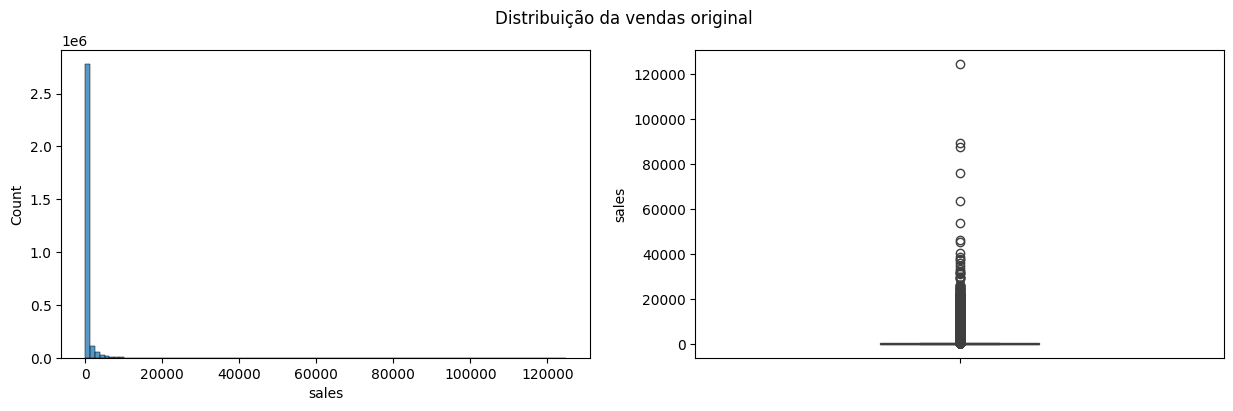

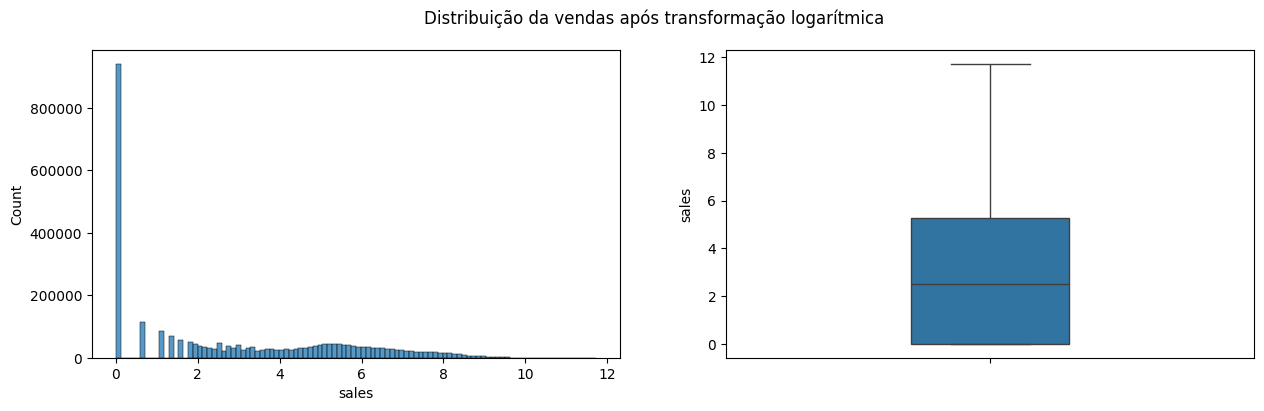

In [268]:
# Gráficos de distribuição da váriavel alvo
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.histplot(train.sales, bins=100)
plt.subplot(1,2,2)
sns.boxplot(train.sales, width=0.3)
plt.suptitle('Distribuição da vendas original')

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.histplot(np.log1p(train.sales), bins=100)
plt.subplot(1,2,2)
sns.boxplot(np.log1p(train.sales), width=0.3)
plt.suptitle('Distribuição da vendas após transformação logarítmica')

plt.show()

### Os totais de venda apresentam, no geral, uma sazonalidade semanal.

Observando a média móvel semanal, notamos uma clara sazonalidade semanal. Utilizaremos essa informação como referência para determinar a quantidade de lag features a serem incluídas no modelo. Essa abordagem permitirá capturar os padrões sazonais recorrentes e, consequentemente, melhorar a precisão das previsões.

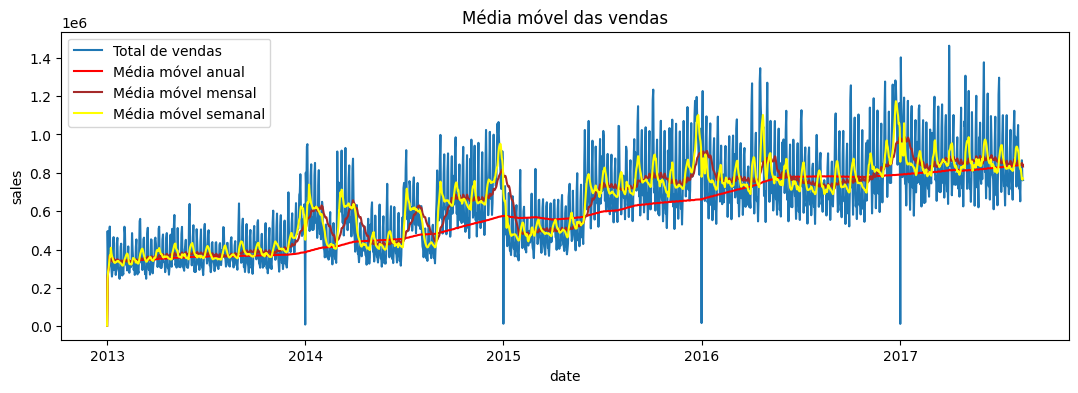

In [269]:
# Médias móveis
sales = data.groupby('date').sales.sum()
plt.figure(figsize=(13, 4))

sns.lineplot(x=sales.index, y=sales, label='Total de vendas')
sns.lineplot(x=sales.index, y=sales.rolling(365, min_periods=1).mean(), label='Média móvel anual', color='red')
sns.lineplot(x=sales.index, y=sales.rolling(30, min_periods=1).mean(), label='Média móvel mensal', color='brown')
sns.lineplot(x=sales.index, y=sales.rolling(7, min_periods=1).mean(), label='Média móvel semanal', color='yellow')

plt.title('Média móvel das vendas')
plt.show()

In [16]:
def make_lags(data, lags, drop_null=True):
    for i in range(lags):
        data.loc[:, f'sales_lag_{i+1}'] = data.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(i+1)
        
    if drop_null:
        data = data.dropna(subset=['sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7'])
        
    return data

In [17]:
data = make_lags(data, 7)

Relação linear entre lag feature e total de vendas

<Axes: xlabel='sales', ylabel='sales_lag_1'>

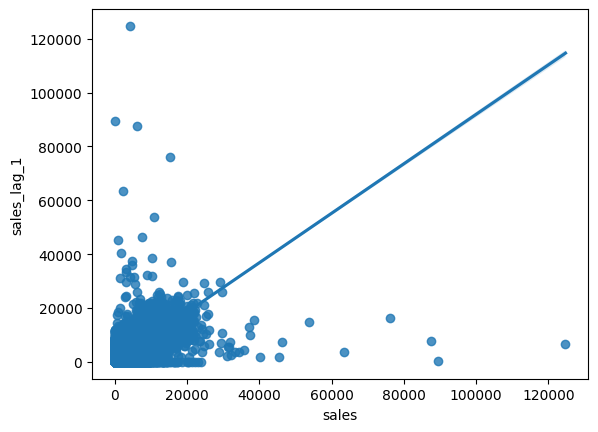

In [241]:
sns.regplot(x=data.sales, y=data.sales_lag_1)

Total de vendas extratificado

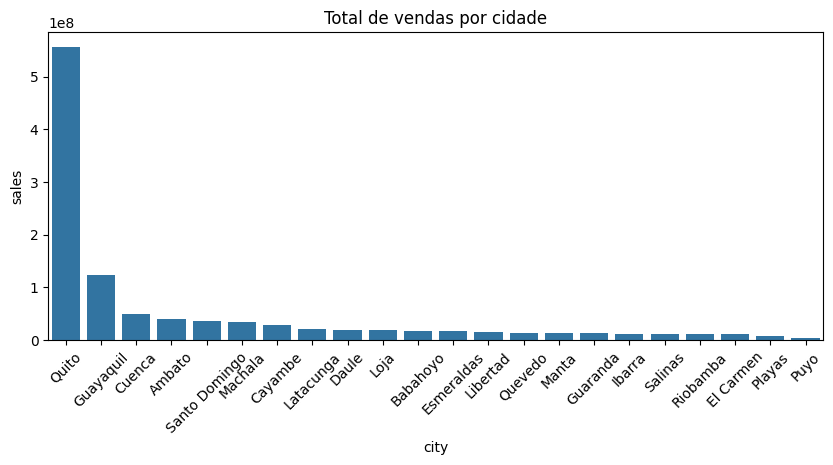

In [225]:
plt.figure(figsize=(10,4))
values = data.groupby('city').sales.sum()
sns.barplot(values, order=values.sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title('Total de vendas por cidade')
plt.show()

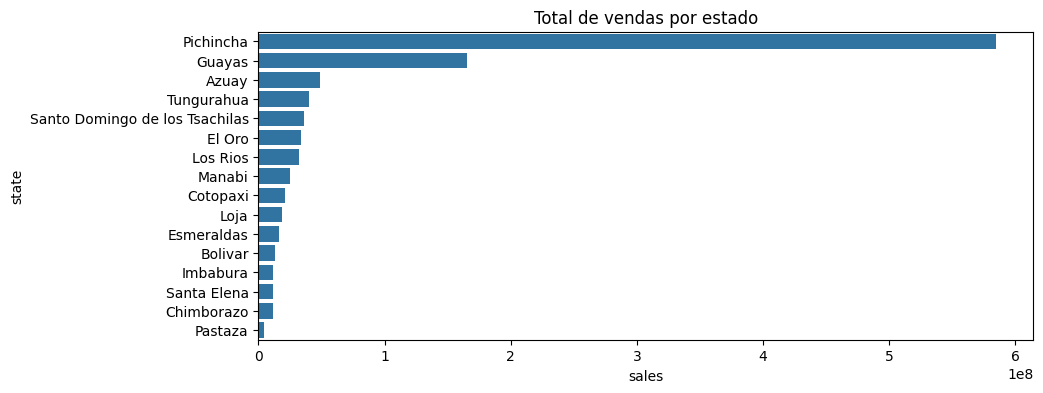

In [231]:
plt.figure(figsize=(10,4))
values = data.groupby('state').sales.sum()
sns.barplot(values, order=values.sort_values(ascending=False).index, orient='h')
plt.title('Total de vendas por estado')
plt.show()

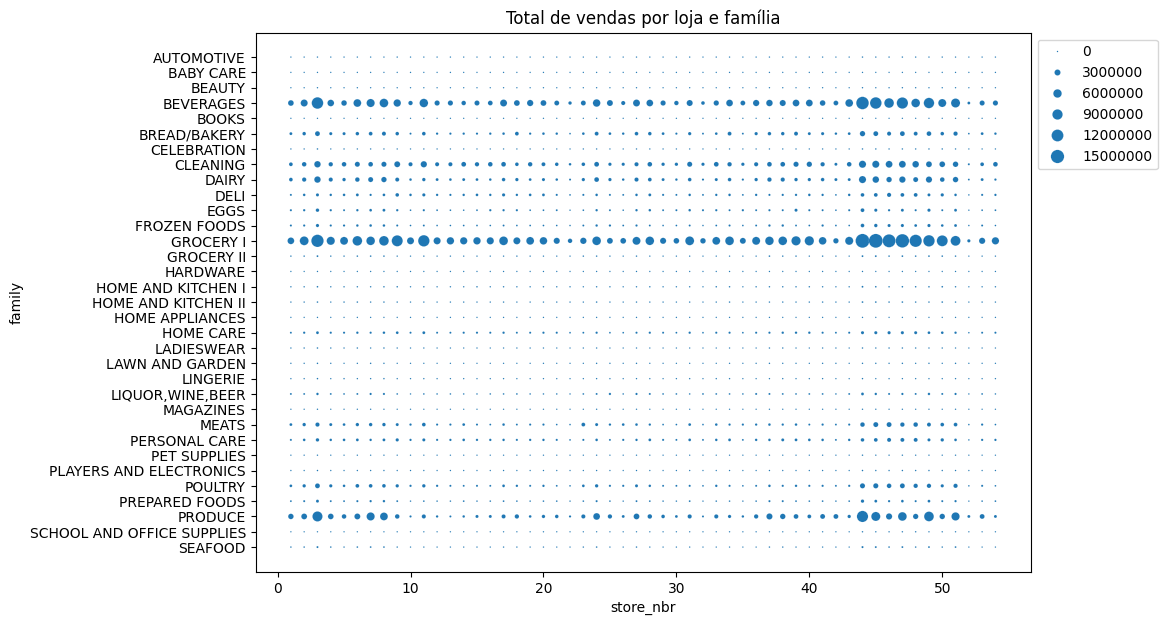

In [213]:
# Total de vendas por loja e família
sales_per_group = train.groupby(['store_nbr', 'family'], as_index=False, observed=False).sales.sum()
sales_per_group['store_nbr'] = sales_per_group['store_nbr'].astype(int)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=sales_per_group, x= 'store_nbr', y='family', size='sales', sizes=(1, 100))

plt.legend(bbox_to_anchor=(1, 1)) # Colocar a legenda fora da área de plotagem
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Total de vendas por loja e família')
plt.show()

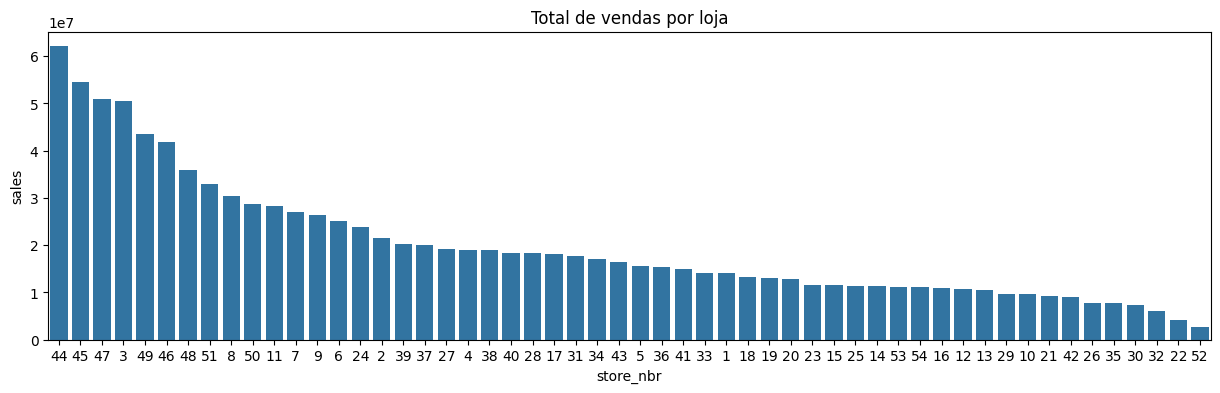

In [188]:
# Total de vendas por loja
plt.figure(figsize=(15,4))
values = train.groupby('store_nbr', observed=False).sales.sum()
sns.barplot(values, orient='v', order=values.sort_values(ascending=False).index)
plt.title('Total de vendas por loja')
plt.show()

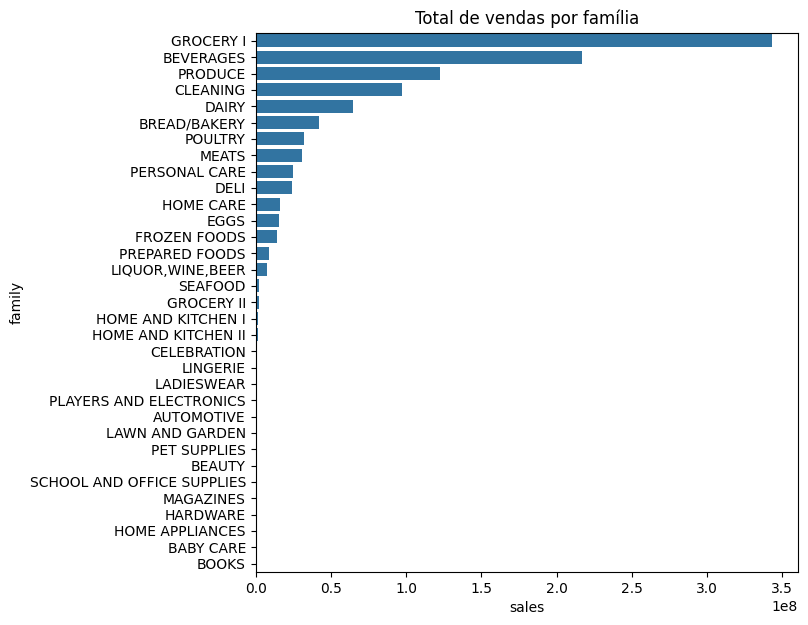

In [189]:
# Total de vendas por família
plt.figure(figsize=(7,7))
values=train.groupby('family', observed=False).sales.sum()
sns.barplot(values, orient='h', order=values.sort_values(ascending=False).index)
plt.title('Total de vendas por família')
plt.show()

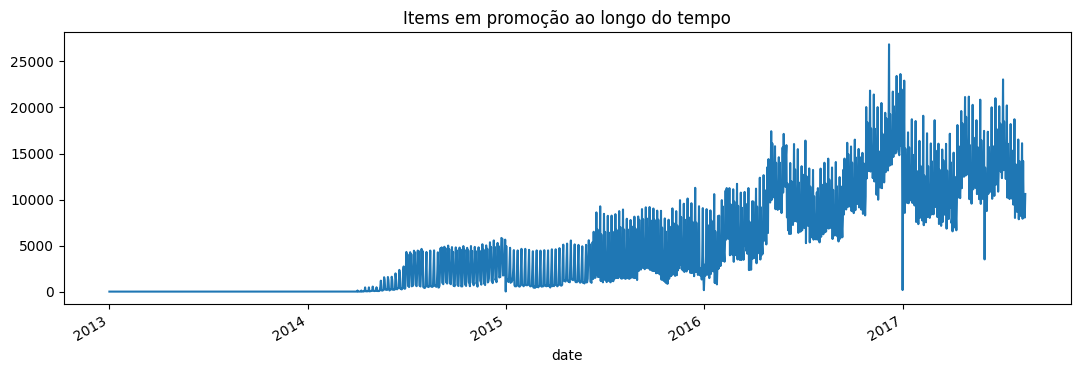

In [ ]:
# Items em promoção ao longo do tempo

train.groupby('date').onpromotion.sum().plot(figsize=(13,4))
plt.title('Items em promoção ao longo do tempo')
plt.show()

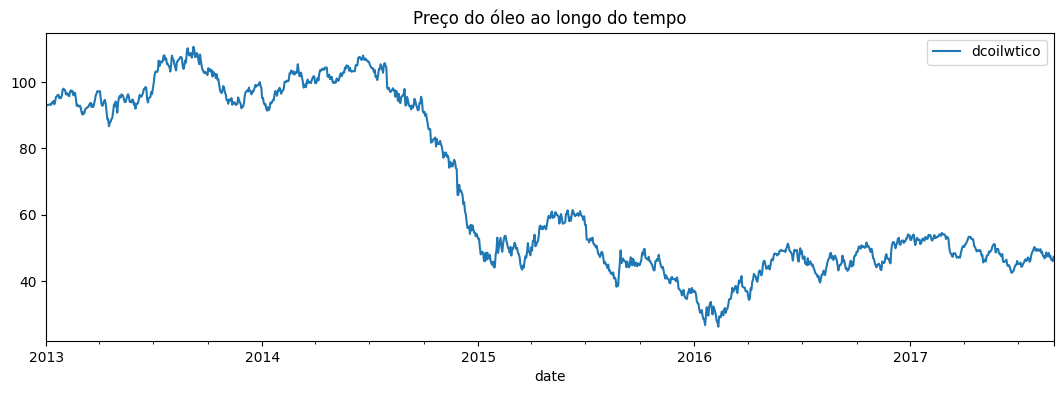

In [ ]:
# Preço do óleo
oil.set_index('date').plot(figsize=(13,4))
plt.title('Preço do óleo ao longo do tempo')
plt.show()

# 4. Treinando modelo

In [18]:
# Função para validação cruzada
def validation(model):
    tss = TimeSeriesSplit(n_splits=5, test_size=16)
    df = data.sort_index().reset_index().drop(columns='date')

    errors = []
    for train_idx, test_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]

        X_train = train.drop(columns='sales')
        y_train = train.sales
        X_test = test.drop(columns='sales')
        y_test = test.sales

        model.fit(X_train, np.log1p(y_train))
        
        y_hat = model.predict(X_test)
        y_hat = np.expm1(np.maximum(y_hat, 0))

        error = root_mean_squared_log_error(y_hat, y_test)
        errors.append(error)
    
    return errors

In [19]:
categ_nom = [
    'store_nbr',
    'family',
    'city',
    'state', 
    'type', 
    'cluster',
    'local_holiday', 
    'regional_holiday',
    'national_holiday', 
    # 'day',
    # 'month', 
    # 'year', 
    # 'dayofyear',
    # 'weekofyear', 
    # 'weekday'
]

numeric_contin = [
    'onpromotion',
    'dcoilwtico',
    'sales_lag_1',
    'sales_lag_2',
    'sales_lag_3',
    'sales_lag_4', 
    'sales_lag_5', 
    'sales_lag_6',
    'sales_lag_7',
    # 'day',
    # 'month', 
    # 'year', 
    # 'dayofyear',
    # 'weekofyear', 
    # 'weekday' 
]


# Criação de Pipeline do modelo
categ_nom_transformer = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(sparse_output=False))
])

numeric_cont_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('variance', VarianceThreshold(threshold=0.5)),
    # ('drop_corr', DropCorrelatedFeatures(threshold=0.25))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categ_nom', categ_nom_transformer, categ_nom),
        ('numeric_cont', numeric_cont_transformer, numeric_contin)
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_jobs=-1, verbose=2)),
])

In [20]:
val = validation(model_pipeline)
print(f"RMSLE: {np.mean(val)}")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.971647
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.467830
[LightGBM] [Debug] init for col-wise cost 0.057977 seconds, init for row-wise cost 0.294399 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 2988334, number of used features: 168
[LightGBM] [Info] Start training from score 2.930853
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a

**Resultados:**

Features de data como numerica: 0.3277474275700829<br>
Features de data como categorica: 0.324988031877876<br>
Com DropCorrelatedFeatures=0.5: 0.35865827167650977<br>
Com DropCorrelatedFeatures=0.25: 0.5733819375091759<br>
Sem features de data: 0.2997036589567574 ---> _Melhor resultado_<br>

## Otimizando modelo

In [48]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 7000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7),
        'num_leaves': trial.suggest_int('num_leaves', 25, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1 ),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
    }

    model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', LGBMRegressor(
                    # n_jobs=-1,
                    verbose=-1,
                    **params)),
            ])

    errors = validation(model)
    print(errors)
    
    return np.mean(errors)


In [50]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-07-20 21:58:39,360] A new study created in memory with name: no-name-e6f71054-10a5-4e54-a3aa-e47de6f6a4c8
Best trial: 0. Best value: 0.288566:   1%|          | 1/100 [02:50<4:40:37, 170.08s/it]

[0.3032541709548162, 0.3705435745504292, 0.21446809200916225, 0.25567465986270077, 0.29888799432694807]
[I 2024-07-20 22:01:29,432] Trial 0 finished with value: 0.2885656983408113 and parameters: {'n_estimators': 949, 'learning_rate': 0.4014473309851709, 'num_leaves': 25, 'min_child_samples': 25, 'min_child_weight': 0.08737826149116548, 'max_depth': 16}. Best is trial 0 with value: 0.2885656983408113.


Best trial: 0. Best value: 0.288566:   2%|▏         | 2/100 [16:22<14:54:56, 547.92s/it]

[0.2943991873202347, 0.3621165584505217, 0.23629064413202988, 0.30413205977621527, 0.26163905677100924]
[I 2024-07-20 22:15:01,845] Trial 1 finished with value: 0.2917155012900021 and parameters: {'n_estimators': 5637, 'learning_rate': 0.41070896727671163, 'num_leaves': 30, 'min_child_samples': 14, 'min_child_weight': 0.009983049352455795, 'max_depth': 12}. Best is trial 0 with value: 0.2885656983408113.


Best trial: 0. Best value: 0.288566:   3%|▎         | 3/100 [22:22<12:27:16, 462.23s/it]

[0.3071623917318501, 0.3576594418252972, 0.20881947487239597, 0.287581791045604, 0.2901488255176752]
[I 2024-07-20 22:21:02,112] Trial 2 finished with value: 0.2902743849985645 and parameters: {'n_estimators': 2795, 'learning_rate': 0.2856505990597385, 'num_leaves': 30, 'min_child_samples': 29, 'min_child_weight': 0.04235358966009191, 'max_depth': 19}. Best is trial 0 with value: 0.2885656983408113.


Best trial: 0. Best value: 0.288566:   4%|▍         | 4/100 [28:01<11:01:50, 413.65s/it]

[0.2867556663058323, 0.325344404416915, 0.20934724145867978, 0.33258302887211927, 0.3024732538259532]
[I 2024-07-20 22:26:41,289] Trial 3 finished with value: 0.29130071897589993 and parameters: {'n_estimators': 2776, 'learning_rate': 0.6595892105055341, 'num_leaves': 36, 'min_child_samples': 20, 'min_child_weight': 0.00667406132228619, 'max_depth': 15}. Best is trial 0 with value: 0.2885656983408113.


Best trial: 4. Best value: 0.27821:   5%|▌         | 5/100 [38:04<12:42:39, 481.68s/it] 

[0.3096571705345302, 0.33981547368987214, 0.19879660807039462, 0.26662537125157965, 0.2761544697124261]
[I 2024-07-20 22:36:43,588] Trial 4 finished with value: 0.27820981865176053 and parameters: {'n_estimators': 5215, 'learning_rate': 0.09954398749217695, 'num_leaves': 40, 'min_child_samples': 16, 'min_child_weight': 0.017036633036166815, 'max_depth': 13}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:   6%|▌         | 6/100 [48:28<13:50:30, 530.11s/it]

[0.3040401361458795, 0.33758742068927355, 0.20480072666386698, 0.2653730631369675, 0.3049186071338932]
[I 2024-07-20 22:47:07,699] Trial 5 finished with value: 0.28334399075397615 and parameters: {'n_estimators': 3939, 'learning_rate': 0.11142399357033862, 'num_leaves': 25, 'min_child_samples': 15, 'min_child_weight': 0.08608836454948812, 'max_depth': 9}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:   7%|▋         | 7/100 [57:13<13:38:54, 528.33s/it]

[0.30788970572856683, 0.34821558063559593, 0.19981255530324746, 0.25732057541293296, 0.2805272539217305]
[I 2024-07-20 22:55:52,352] Trial 6 finished with value: 0.2787531342004147 and parameters: {'n_estimators': 3761, 'learning_rate': 0.09190576737550471, 'num_leaves': 31, 'min_child_samples': 12, 'min_child_weight': 0.03749771263414095, 'max_depth': 11}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:   8%|▊         | 8/100 [1:13:04<16:56:33, 662.97s/it]

[0.30965196221476293, 0.3592668016778963, 0.21435692446862237, 0.27784202723441537, 0.29553177686779386]
[I 2024-07-20 23:11:43,623] Trial 7 finished with value: 0.29132989849269814 and parameters: {'n_estimators': 6314, 'learning_rate': 0.18348914587515824, 'num_leaves': 35, 'min_child_samples': 12, 'min_child_weight': 0.08248878659100546, 'max_depth': 19}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:   9%|▉         | 9/100 [1:28:39<18:54:32, 748.05s/it]

[0.3224032993241276, 0.35935195679123094, 0.216428882141988, 0.26496758810564214, 0.27826377657364304]
[I 2024-07-20 23:27:18,766] Trial 8 finished with value: 0.28828310058732637 and parameters: {'n_estimators': 6815, 'learning_rate': 0.11535437042023368, 'num_leaves': 34, 'min_child_samples': 26, 'min_child_weight': 0.010044612846185602, 'max_depth': 10}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  10%|█         | 10/100 [1:42:31<19:20:46, 773.85s/it]

[0.32779828056236565, 0.3559226980938453, 0.21138649251049166, 0.3356567527074173, 0.2594640275780757]
[I 2024-07-20 23:41:10,390] Trial 9 finished with value: 0.2980456502904391 and parameters: {'n_estimators': 6146, 'learning_rate': 0.6468733627087997, 'num_leaves': 39, 'min_child_samples': 30, 'min_child_weight': 0.06387462084227213, 'max_depth': 20}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  11%|█         | 11/100 [1:58:19<20:26:59, 827.18s/it]

[0.30484155632161125, 0.3480456015233701, 0.21175403179593943, 0.2451200312524079, 0.3168809039874908]
[I 2024-07-20 23:56:58,487] Trial 10 finished with value: 0.28532842497616395 and parameters: {'n_estimators': 5033, 'learning_rate': 0.016150004249256084, 'num_leaves': 40, 'min_child_samples': 18, 'min_child_weight': 0.027560358611006, 'max_depth': 5}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  12%|█▏        | 12/100 [2:08:13<18:29:12, 756.28s/it]

[0.32312222506563065, 0.4050726952169616, 0.1739244602825164, 0.28196368086797535, 0.2823654275217346]
[I 2024-07-21 00:06:52,604] Trial 11 finished with value: 0.2932896977909637 and parameters: {'n_estimators': 4374, 'learning_rate': 0.2696841214092806, 'num_leaves': 31, 'min_child_samples': 10, 'min_child_weight': 0.03373064445576753, 'max_depth': 13}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  13%|█▎        | 13/100 [2:16:47<16:30:12, 682.91s/it]

[0.3075774550373001, 0.34061202527882417, 0.2206352800695876, 0.25484951370857717, 0.3241352293308017]
[I 2024-07-21 00:15:26,668] Trial 12 finished with value: 0.2895619006850182 and parameters: {'n_estimators': 2926, 'learning_rate': 0.018619576952653857, 'num_leaves': 28, 'min_child_samples': 17, 'min_child_weight': 0.05876863685582312, 'max_depth': 8}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  14%|█▍        | 14/100 [2:19:36<12:36:19, 527.67s/it]

[0.3062868838698597, 0.34013954598170826, 0.21212756208793684, 0.2809276269067602, 0.282528839256409]
[I 2024-07-21 00:18:15,631] Trial 13 finished with value: 0.28440209162053476 and parameters: {'n_estimators': 757, 'learning_rate': 0.5326903317974341, 'num_leaves': 37, 'min_child_samples': 10, 'min_child_weight': 0.025385171654159364, 'max_depth': 12}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  15%|█▌        | 15/100 [2:30:07<13:11:55, 559.00s/it]

[0.3161135690479992, 0.3698613787494501, 0.20012019624853214, 0.2686240705829571, 0.29973630154002806]
[I 2024-07-21 00:28:47,246] Trial 14 finished with value: 0.29089110323379336 and parameters: {'n_estimators': 4700, 'learning_rate': 0.178162705621314, 'num_leaves': 33, 'min_child_samples': 14, 'min_child_weight': 0.0473973616272317, 'max_depth': 15}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  16%|█▌        | 16/100 [2:35:20<11:18:46, 484.84s/it]

[0.30466250644518805, 0.35827886655219165, 0.20808968654540896, 0.27290072894981054, 0.2951069917500205]
[I 2024-07-21 00:33:59,846] Trial 15 finished with value: 0.2878077560485239 and parameters: {'n_estimators': 1806, 'learning_rate': 0.2650957765384291, 'num_leaves': 28, 'min_child_samples': 21, 'min_child_weight': 0.02253451821919714, 'max_depth': 6}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  17%|█▋        | 17/100 [2:44:04<11:26:46, 496.47s/it]

[0.31750359237745485, 0.3394096570972158, 0.2002290766665796, 0.2590628762000537, 0.2845572165972452]
[I 2024-07-21 00:42:43,367] Trial 16 finished with value: 0.28015248378770985 and parameters: {'n_estimators': 3611, 'learning_rate': 0.0837771688181383, 'num_leaves': 38, 'min_child_samples': 17, 'min_child_weight': 0.0697838467429345, 'max_depth': 11}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  18%|█▊        | 18/100 [2:55:42<12:41:32, 557.23s/it]

[0.3205115534426511, 0.36759190815169934, 0.2045539986527123, 0.2754334393367829, 0.28813812260223676]
[I 2024-07-21 00:54:22,036] Trial 17 finished with value: 0.2912458044372165 and parameters: {'n_estimators': 5310, 'learning_rate': 0.19672524236828062, 'num_leaves': 32, 'min_child_samples': 21, 'min_child_weight': 0.03777010057573991, 'max_depth': 14}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  19%|█▉        | 19/100 [3:00:48<10:50:11, 481.62s/it]

[0.31102277410911167, 0.3632482592723488, 0.21938474700538987, 0.2682971722276979, 0.2646121658771119]
[I 2024-07-21 00:59:27,530] Trial 18 finished with value: 0.285313023698332 and parameters: {'n_estimators': 1907, 'learning_rate': 0.33324287308603423, 'num_leaves': 27, 'min_child_samples': 12, 'min_child_weight': 0.017638476882935912, 'max_depth': 7}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  20%|██        | 20/100 [3:10:33<11:23:46, 512.83s/it]

[0.31541410982035234, 0.3523368873331479, 0.20552950268196585, 0.2588343873869398, 0.28884465456136366]
[I 2024-07-21 01:09:13,085] Trial 19 finished with value: 0.28419190835675395 and parameters: {'n_estimators': 4182, 'learning_rate': 0.07309143973723391, 'num_leaves': 34, 'min_child_samples': 15, 'min_child_weight': 0.052717479573020976, 'max_depth': 17}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  21%|██        | 21/100 [3:17:58<10:48:21, 492.42s/it]

[0.33174072687312745, 0.39556581426402526, 0.21391300383135153, 0.26451573836060577, 0.27494574081938533]
[I 2024-07-21 01:16:37,941] Trial 20 finished with value: 0.29613620482969905 and parameters: {'n_estimators': 3151, 'learning_rate': 0.47870268011912065, 'num_leaves': 36, 'min_child_samples': 24, 'min_child_weight': 0.0027850365935044637, 'max_depth': 10}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 4. Best value: 0.27821:  22%|██▏       | 22/100 [3:26:00<10:36:03, 489.28s/it]

[0.30541008171625494, 0.3650550489953069, 0.2059735673454402, 0.2785840862957207, 0.30673876537242445]
[I 2024-07-21 01:24:39,885] Trial 21 finished with value: 0.2923523099450295 and parameters: {'n_estimators': 3370, 'learning_rate': 0.13207305238840597, 'num_leaves': 38, 'min_child_samples': 18, 'min_child_weight': 0.06560191291616749, 'max_depth': 11}. Best is trial 4 with value: 0.27820981865176053.


Best trial: 22. Best value: 0.277592:  23%|██▎       | 23/100 [3:35:00<10:47:33, 504.59s/it]

[0.3084803082547915, 0.34403028105432265, 0.2028637494523323, 0.25240982045392957, 0.28017719817445763]
[I 2024-07-21 01:33:40,178] Trial 22 finished with value: 0.2775922714779667 and parameters: {'n_estimators': 3698, 'learning_rate': 0.06736078160764189, 'num_leaves': 40, 'min_child_samples': 17, 'min_child_weight': 0.09952044095730024, 'max_depth': 13}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  24%|██▍       | 24/100 [3:42:50<10:25:50, 494.08s/it]

[0.3042399679951554, 0.3375378003578509, 0.22690502159530646, 0.250298968655437, 0.3375919053098836]
[I 2024-07-21 01:41:29,755] Trial 23 finished with value: 0.2913147327827267 and parameters: {'n_estimators': 2123, 'learning_rate': 0.011464123273161417, 'num_leaves': 39, 'min_child_samples': 12, 'min_child_weight': 0.09652053374784994, 'max_depth': 13}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  25%|██▌       | 25/100 [3:53:21<11:08:58, 535.19s/it]

[0.3149035195224304, 0.38413752415500035, 0.1888192945850611, 0.284839947198867, 0.30386681736200366]
[I 2024-07-21 01:52:00,830] Trial 24 finished with value: 0.29531342056467247 and parameters: {'n_estimators': 4711, 'learning_rate': 0.19919846771699937, 'num_leaves': 40, 'min_child_samples': 16, 'min_child_weight': 0.03384564734196578, 'max_depth': 14}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  26%|██▌       | 26/100 [4:05:53<12:20:24, 600.33s/it]

[0.3125332722471992, 0.36216233555920124, 0.20953206216120981, 0.25831769432637197, 0.27546464276549953]
[I 2024-07-21 02:04:33,149] Trial 25 finished with value: 0.28360200141189634 and parameters: {'n_estimators': 5629, 'learning_rate': 0.05975171793446558, 'num_leaves': 32, 'min_child_samples': 19, 'min_child_weight': 0.01645621685850679, 'max_depth': 9}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  27%|██▋       | 27/100 [4:15:12<11:55:21, 587.96s/it]

[0.3116613475125418, 0.36633278011744935, 0.19705758229733, 0.28096231406557565, 0.27027547730777357]
[I 2024-07-21 02:13:52,261] Trial 26 finished with value: 0.2852579002601341 and parameters: {'n_estimators': 4143, 'learning_rate': 0.23794988105337134, 'num_leaves': 37, 'min_child_samples': 13, 'min_child_weight': 0.07422550556545608, 'max_depth': 17}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  28%|██▊       | 28/100 [4:23:34<11:14:29, 562.07s/it]

[0.30908045904239495, 0.34371059497096407, 0.20613267653718007, 0.26595727318348816, 0.2803249290070156]
[I 2024-07-21 02:22:13,914] Trial 27 finished with value: 0.28104118654820853 and parameters: {'n_estimators': 3581, 'learning_rate': 0.15340284090761577, 'num_leaves': 40, 'min_child_samples': 16, 'min_child_weight': 0.09902747094066676, 'max_depth': 11}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 22. Best value: 0.277592:  29%|██▉       | 29/100 [4:29:44<9:56:43, 504.28s/it] 

[0.2991666891914765, 0.3325839558879646, 0.20368435838321744, 0.25585042656093565, 0.29721866378773726]
[I 2024-07-21 02:28:23,359] Trial 28 finished with value: 0.27770081876226627 and parameters: {'n_estimators': 2446, 'learning_rate': 0.08801137921777231, 'num_leaves': 30, 'min_child_samples': 22, 'min_child_weight': 0.05176381599210723, 'max_depth': 14}. Best is trial 22 with value: 0.2775922714779667.


Best trial: 29. Best value: 0.272901:  30%|███       | 30/100 [4:33:38<8:14:00, 423.43s/it]

[0.304188014005957, 0.3290545256739149, 0.20354053267586023, 0.24782878449605825, 0.27989210445152035]
[I 2024-07-21 02:32:18,155] Trial 29 finished with value: 0.27290079226066216 and parameters: {'n_estimators': 1381, 'learning_rate': 0.39168448692914676, 'num_leaves': 29, 'min_child_samples': 23, 'min_child_weight': 0.08043993679621202, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  31%|███       | 31/100 [4:37:29<7:00:27, 365.62s/it]

[0.3091059806726524, 0.32972757482311443, 0.18879025722922566, 0.277679736180291, 0.26735114658364706]
[I 2024-07-21 02:36:08,887] Trial 30 finished with value: 0.2745309390977861 and parameters: {'n_estimators': 1358, 'learning_rate': 0.39876216166321465, 'num_leaves': 29, 'min_child_samples': 24, 'min_child_weight': 0.07838759958765926, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  32%|███▏      | 32/100 [4:39:16<5:26:31, 288.12s/it]

[0.31407305375240085, 0.32044381250565895, 0.21795191289736948, 0.2684788114054499, 0.31461570027341784]
[I 2024-07-21 02:37:56,162] Trial 31 finished with value: 0.2871126581668594 and parameters: {'n_estimators': 317, 'learning_rate': 0.4371878490406023, 'num_leaves': 29, 'min_child_samples': 23, 'min_child_weight': 0.07961838377089396, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  33%|███▎      | 33/100 [4:43:12<5:04:06, 272.34s/it]

[0.29661643289171674, 0.33185829545774076, 0.19165941495812225, 0.27945063606861675, 0.2964950985930494]
[I 2024-07-21 02:41:51,692] Trial 32 finished with value: 0.2792159755938492 and parameters: {'n_estimators': 1366, 'learning_rate': 0.3565650697090107, 'num_leaves': 27, 'min_child_samples': 26, 'min_child_weight': 0.09376664572296388, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  34%|███▍      | 34/100 [4:49:02<5:25:22, 295.80s/it]

[0.32003533718322874, 0.3468275712667971, 0.19662860273398924, 0.2782291666344623, 0.30368362077604716]
[I 2024-07-21 02:47:42,231] Trial 33 finished with value: 0.2890808597189049 and parameters: {'n_estimators': 2388, 'learning_rate': 0.35129544754025516, 'num_leaves': 30, 'min_child_samples': 23, 'min_child_weight': 0.09282617158365916, 'max_depth': 18}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  35%|███▌      | 35/100 [4:52:41<4:55:16, 272.56s/it]

[0.3105327350739832, 0.3281957489443654, 0.20585825029833346, 0.25419383636180976, 0.2816061221462297]
[I 2024-07-21 02:51:20,572] Trial 34 finished with value: 0.2760773385649443 and parameters: {'n_estimators': 1260, 'learning_rate': 0.5159267998566422, 'num_leaves': 25, 'min_child_samples': 27, 'min_child_weight': 0.07712574869077901, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  36%|███▌      | 36/100 [4:56:24<4:35:05, 257.90s/it]

[0.3153862816354173, 0.36821831734373056, 0.2105143457072054, 0.29424539693949353, 0.27206790597881614]
[I 2024-07-21 02:55:04,274] Trial 35 finished with value: 0.2920864495209326 and parameters: {'n_estimators': 1287, 'learning_rate': 0.5597957332210625, 'num_leaves': 25, 'min_child_samples': 27, 'min_child_weight': 0.07722006025384814, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  37%|███▋      | 37/100 [4:58:28<3:48:21, 217.48s/it]

[0.3138103300176635, 0.35888285516593255, 0.2115439789782536, 0.2751961121307959, 0.30711349357687256]
[I 2024-07-21 02:57:07,433] Trial 36 finished with value: 0.2933093539739036 and parameters: {'n_estimators': 422, 'learning_rate': 0.41569815271670457, 'num_leaves': 26, 'min_child_samples': 29, 'min_child_weight': 0.08646668037255661, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  38%|███▊      | 38/100 [5:02:21<3:49:34, 222.17s/it]

[0.3034653787941693, 0.3863951768342319, 0.20968422800042877, 0.28436470032340566, 0.2820259822049839]
[I 2024-07-21 03:01:00,553] Trial 37 finished with value: 0.2931870932314439 and parameters: {'n_estimators': 1407, 'learning_rate': 0.47092558171117754, 'num_leaves': 26, 'min_child_samples': 25, 'min_child_weight': 0.09065254388251963, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  39%|███▉      | 39/100 [5:05:15<3:31:10, 207.71s/it]

[0.32069954119698935, 0.331264329776574, 0.2124347230480106, 0.2898295965704814, 0.29718206717158335]
[I 2024-07-21 03:03:54,521] Trial 38 finished with value: 0.2902820515527277 and parameters: {'n_estimators': 882, 'learning_rate': 0.5822063940174927, 'num_leaves': 29, 'min_child_samples': 28, 'min_child_weight': 0.07285690006877663, 'max_depth': 18}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  40%|████      | 40/100 [5:09:51<3:48:16, 228.27s/it]

[0.2984430227450967, 0.3556276427369207, 0.21418278050084766, 0.28069089119337837, 0.2636259258388507]
[I 2024-07-21 03:08:30,770] Trial 39 finished with value: 0.2825140526030188 and parameters: {'n_estimators': 1744, 'learning_rate': 0.3182820756546409, 'num_leaves': 28, 'min_child_samples': 25, 'min_child_weight': 0.08445363966133829, 'max_depth': 18}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  41%|████      | 41/100 [5:11:30<3:06:24, 189.57s/it]

[0.32050952798706495, 0.33812835091662546, 0.24028232058290316, 0.2841348733860883, 0.31264869999882006]
[I 2024-07-21 03:10:10,039] Trial 40 finished with value: 0.2991407545743004 and parameters: {'n_estimators': 146, 'learning_rate': 0.38447661251185306, 'num_leaves': 26, 'min_child_samples': 20, 'min_child_weight': 0.07978331603588076, 'max_depth': 20}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  42%|████▏     | 42/100 [5:17:31<3:52:47, 240.81s/it]

[0.3193324257264973, 0.4449067346805022, 0.1782287443497603, 0.29809202229116744, 0.24231371240623467]
[I 2024-07-21 03:16:10,409] Trial 41 finished with value: 0.2965747278908324 and parameters: {'n_estimators': 2473, 'learning_rate': 0.49311184574125144, 'num_leaves': 30, 'min_child_samples': 22, 'min_child_weight': 0.05716291302484307, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  43%|████▎     | 43/100 [5:23:45<4:26:53, 280.94s/it]

[0.3103208827686275, 0.3682632044539054, 0.21332952584377762, 0.27373236253775685, 0.25961114224005843]
[I 2024-07-21 03:22:24,986] Trial 42 finished with value: 0.2850514235688252 and parameters: {'n_estimators': 2584, 'learning_rate': 0.3976858452046895, 'num_leaves': 31, 'min_child_samples': 23, 'min_child_weight': 0.06388995261398908, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  44%|████▍     | 44/100 [5:27:19<4:03:33, 260.95s/it]

[0.3227340470470279, 0.3507724366041862, 0.19607902924737586, 0.29072359188307517, 0.26604549078672796]
[I 2024-07-21 03:25:59,287] Trial 43 finished with value: 0.28527091911367863 and parameters: {'n_estimators': 1211, 'learning_rate': 0.44786933513572014, 'num_leaves': 29, 'min_child_samples': 24, 'min_child_weight': 0.06812602769984255, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  45%|████▌     | 45/100 [5:29:40<3:26:07, 224.87s/it]

[0.3081556102109372, 0.36706338231680014, 0.21078965773792419, 0.2758430273871316, 0.3158819114067666]
[I 2024-07-21 03:28:19,967] Trial 44 finished with value: 0.2955467178119119 and parameters: {'n_estimators': 596, 'learning_rate': 0.6158467956517724, 'num_leaves': 31, 'min_child_samples': 26, 'min_child_weight': 0.08975557906259182, 'max_depth': 12}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  46%|████▌     | 46/100 [5:32:51<3:13:12, 214.68s/it]

[0.2964234597788581, 0.3526761724294778, 0.1833864155977873, 0.2920021526953673, 0.3062860319616643]
[I 2024-07-21 03:31:30,893] Trial 45 finished with value: 0.28615484649263095 and parameters: {'n_estimators': 1053, 'learning_rate': 0.5334475343352019, 'num_leaves': 27, 'min_child_samples': 21, 'min_child_weight': 0.04654009207388855, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  47%|████▋     | 47/100 [5:38:15<3:38:36, 247.48s/it]

[0.3063661703203473, 0.34716236394713096, 0.21621020510895353, 0.28897100400510595, 0.27391984394078367]
[I 2024-07-21 03:36:54,908] Trial 46 finished with value: 0.28652591746446426 and parameters: {'n_estimators': 2149, 'learning_rate': 0.297544494953753, 'num_leaves': 29, 'min_child_samples': 27, 'min_child_weight': 0.05702107232735398, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  48%|████▊     | 48/100 [5:42:31<3:36:46, 250.12s/it]

[0.31434439694207733, 0.3673904552398774, 0.21184041555472388, 0.25931804911449946, 0.26905182288536383]
[I 2024-07-21 03:41:11,169] Trial 47 finished with value: 0.28438902794730836 and parameters: {'n_estimators': 1559, 'learning_rate': 0.677064400174497, 'num_leaves': 33, 'min_child_samples': 22, 'min_child_weight': 0.07532877984808434, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  49%|████▉     | 49/100 [5:48:59<4:07:35, 291.28s/it]

[0.3187586722375867, 0.35667578981857556, 0.21812557419330722, 0.31271071311877, 0.3035397003546585]
[I 2024-07-21 03:47:38,481] Trial 48 finished with value: 0.3019620899445796 and parameters: {'n_estimators': 2713, 'learning_rate': 0.5073966844933924, 'num_leaves': 30, 'min_child_samples': 24, 'min_child_weight': 0.08236401498222443, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  50%|█████     | 50/100 [5:56:05<4:36:32, 331.86s/it]

[0.304732236604391, 0.36983582812900434, 0.20184991315524614, 0.27859762187216286, 0.30898162780313926]
[I 2024-07-21 03:54:45,023] Trial 49 finished with value: 0.2927994455127887 and parameters: {'n_estimators': 3031, 'learning_rate': 0.2380497773497139, 'num_leaves': 34, 'min_child_samples': 20, 'min_child_weight': 0.07089017055693002, 'max_depth': 19}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  51%|█████     | 51/100 [5:59:47<4:03:58, 298.75s/it]

[0.3029923692275405, 0.34318256062865377, 0.22241919809041033, 0.25851834725366246, 0.33210086107047804]
[I 2024-07-21 03:58:26,539] Trial 50 finished with value: 0.29184266725414904 and parameters: {'n_estimators': 1018, 'learning_rate': 0.04385138039738229, 'num_leaves': 28, 'min_child_samples': 22, 'min_child_weight': 0.061665239287842843, 'max_depth': 12}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  52%|█████▏    | 52/100 [6:13:34<6:05:46, 457.23s/it]

[0.31382343031823534, 0.3471041914693754, 0.20281556559971853, 0.27607338063620157, 0.28341043204931615]
[I 2024-07-21 04:12:13,543] Trial 51 finished with value: 0.28464540001456945 and parameters: {'n_estimators': 6347, 'learning_rate': 0.10543169495433305, 'num_leaves': 39, 'min_child_samples': 19, 'min_child_weight': 0.04076390422377332, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  53%|█████▎    | 53/100 [6:19:04<5:28:17, 419.10s/it]

[0.3061512455820277, 0.3492776951388168, 0.2123113157210954, 0.27216211180640854, 0.29505957673225175]
[I 2024-07-21 04:17:43,687] Trial 52 finished with value: 0.28699238899612 and parameters: {'n_estimators': 2116, 'learning_rate': 0.15260709104468329, 'num_leaves': 38, 'min_child_samples': 30, 'min_child_weight': 0.050149424691013286, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  54%|█████▍    | 54/100 [6:32:31<6:50:28, 535.39s/it]

[0.30801810498813537, 0.3429921650952786, 0.20458437869917453, 0.25603400417829647, 0.293494230002616]
[I 2024-07-21 04:31:10,424] Trial 53 finished with value: 0.2810245765927002 and parameters: {'n_estimators': 5988, 'learning_rate': 0.04436443859168415, 'num_leaves': 32, 'min_child_samples': 17, 'min_child_weight': 0.09888110286891226, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  55%|█████▌    | 55/100 [6:47:07<7:58:20, 637.78s/it]

[0.31361888786001335, 0.3727645750840595, 0.2017301761999607, 0.28609188421227705, 0.2733904714871283]
[I 2024-07-21 04:45:47,098] Trial 54 finished with value: 0.2895191989686877 and parameters: {'n_estimators': 6841, 'learning_rate': 0.1283100554315574, 'num_leaves': 39, 'min_child_samples': 15, 'min_child_weight': 0.08836510659199878, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  56%|█████▌    | 56/100 [6:51:32<6:25:36, 525.82s/it]

[0.30107381929887767, 0.3463640855248027, 0.22918601164315697, 0.2805364669610944, 0.2795642110590423]
[I 2024-07-21 04:50:11,685] Trial 55 finished with value: 0.28734491889739483 and parameters: {'n_estimators': 1612, 'learning_rate': 0.3722115827992003, 'num_leaves': 35, 'min_child_samples': 19, 'min_child_weight': 0.010277357914738015, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  57%|█████▋    | 57/100 [6:58:57<5:59:27, 501.57s/it]

[0.3314437524927987, 0.34859382721354937, 0.1950471814806816, 0.28269295551221263, 0.2660239055980571]
[I 2024-07-21 04:57:36,672] Trial 56 finished with value: 0.28476032445945987 and parameters: {'n_estimators': 3235, 'learning_rate': 0.4243429579750217, 'num_leaves': 28, 'min_child_samples': 18, 'min_child_weight': 0.0818497120019035, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  58%|█████▊    | 58/100 [7:09:09<6:14:13, 534.60s/it]

[0.30976783575474, 0.3689869516551105, 0.20814564001456348, 0.2584664683044306, 0.28789974601949087]
[I 2024-07-21 05:07:48,354] Trial 57 finished with value: 0.2866533283496671 and parameters: {'n_estimators': 4609, 'learning_rate': 0.08026836997905382, 'num_leaves': 25, 'min_child_samples': 14, 'min_child_weight': 0.06739663602040316, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  59%|█████▉    | 59/100 [7:17:43<6:01:12, 528.60s/it]

[0.31767264503855486, 0.3293888738736645, 0.19506650203768128, 0.3120089227577598, 0.3213980171194126]
[I 2024-07-21 05:16:22,937] Trial 58 finished with value: 0.2951069921654146 and parameters: {'n_estimators': 3868, 'learning_rate': 0.46008087724741853, 'num_leaves': 30, 'min_child_samples': 25, 'min_child_weight': 0.027967221881111684, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  60%|██████    | 60/100 [7:28:50<6:20:09, 570.24s/it]

[0.29981981480268693, 0.3852069964638779, 0.19990505412845083, 0.2714462488677497, 0.29498388298977435]
[I 2024-07-21 05:27:30,331] Trial 59 finished with value: 0.290272399450508 and parameters: {'n_estimators': 5125, 'learning_rate': 0.22683828586841617, 'num_leaves': 37, 'min_child_samples': 16, 'min_child_weight': 0.05402010041871713, 'max_depth': 12}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  61%|██████    | 61/100 [7:33:49<5:17:36, 488.63s/it]

[0.3145208830760346, 0.3529394055330342, 0.20444717816296498, 0.2684863396254377, 0.2937826605901602]
[I 2024-07-21 05:32:28,540] Trial 60 finished with value: 0.28683529339752634 and parameters: {'n_estimators': 1948, 'learning_rate': 0.15996052595546362, 'num_leaves': 27, 'min_child_samples': 21, 'min_child_weight': 0.06065315299167934, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  62%|██████▏   | 62/100 [7:42:16<5:13:06, 494.37s/it]

[0.3175314547100393, 0.35428248757272857, 0.20906458175469708, 0.2634135048371935, 0.2905286756485389]
[I 2024-07-21 05:40:56,323] Trial 61 finished with value: 0.28696414090463945 and parameters: {'n_estimators': 3675, 'learning_rate': 0.10525139874501195, 'num_leaves': 31, 'min_child_samples': 13, 'min_child_weight': 0.03250541115106649, 'max_depth': 10}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  63%|██████▎   | 63/100 [7:53:03<5:32:56, 539.91s/it]

[0.30611755236069665, 0.34193341855851206, 0.20238292744366854, 0.25620334139268536, 0.2902875911187181]
[I 2024-07-21 05:51:42,490] Trial 62 finished with value: 0.27938496617485614 and parameters: {'n_estimators': 4464, 'learning_rate': 0.03906826466935641, 'num_leaves': 40, 'min_child_samples': 11, 'min_child_weight': 0.014209711046938377, 'max_depth': 11}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  64%|██████▍   | 64/100 [8:02:07<5:24:48, 541.35s/it]

[0.31754621655431214, 0.3549703739105601, 0.21127567163148175, 0.25273478273793626, 0.2825498583264691]
[I 2024-07-21 06:00:47,179] Trial 63 finished with value: 0.28381538063215184 and parameters: {'n_estimators': 3987, 'learning_rate': 0.10081058750327156, 'num_leaves': 33, 'min_child_samples': 27, 'min_child_weight': 0.04295622684770364, 'max_depth': 12}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  65%|██████▌   | 65/100 [8:05:00<4:11:17, 430.80s/it]

[0.3116512527373723, 0.3336721892706814, 0.22591313805359547, 0.2508496884415311, 0.335331522303993]
[I 2024-07-21 06:03:40,030] Trial 64 finished with value: 0.2914835581614347 and parameters: {'n_estimators': 714, 'learning_rate': 0.06284393632774306, 'num_leaves': 31, 'min_child_samples': 11, 'min_child_weight': 0.019791788195873405, 'max_depth': 10}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  66%|██████▌   | 66/100 [8:13:43<4:19:46, 458.43s/it]

[0.3107866252009097, 0.34444113343377164, 0.2165203766167086, 0.25571181375873, 0.3172016661385735]
[I 2024-07-21 06:12:22,933] Trial 65 finished with value: 0.28893232302973865 and parameters: {'n_estimators': 3365, 'learning_rate': 0.026623330083934096, 'num_leaves': 29, 'min_child_samples': 14, 'min_child_weight': 0.02529126371112419, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  67%|██████▋   | 67/100 [8:20:35<4:04:27, 444.47s/it]

[0.3048220510850068, 0.32585467275725305, 0.20118112984946726, 0.27822630322876074, 0.30051231974006104]
[I 2024-07-21 06:19:14,828] Trial 66 finished with value: 0.2821192953321098 and parameters: {'n_estimators': 2850, 'learning_rate': 0.13671446511922467, 'num_leaves': 32, 'min_child_samples': 23, 'min_child_weight': 0.07735960839849358, 'max_depth': 9}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  68%|██████▊   | 68/100 [8:31:04<4:26:36, 499.91s/it]

[0.3170264008122743, 0.37267543541515225, 0.20696932623203895, 0.2772033454724198, 0.3030317889709358]
[I 2024-07-21 06:29:44,084] Trial 67 finished with value: 0.2953812593805642 and parameters: {'n_estimators': 4840, 'learning_rate': 0.17841487459165756, 'num_leaves': 30, 'min_child_samples': 13, 'min_child_weight': 0.09479604963957095, 'max_depth': 11}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  69%|██████▉   | 69/100 [8:43:08<4:53:02, 567.18s/it]

[0.31363586021124856, 0.3344383365799939, 0.19719896961611869, 0.2763631860288982, 0.2726694668544296]
[I 2024-07-21 06:41:48,244] Trial 68 finished with value: 0.2788611638581378 and parameters: {'n_estimators': 5420, 'learning_rate': 0.0891927211756361, 'num_leaves': 40, 'min_child_samples': 29, 'min_child_weight': 0.03582456538226044, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  70%|███████   | 70/100 [8:48:46<4:09:13, 498.46s/it]

[0.3104639904295158, 0.40691198679461676, 0.20846659527388853, 0.2886512524623122, 0.2870148015585426]
[I 2024-07-21 06:47:26,351] Trial 69 finished with value: 0.3003017253037752 and parameters: {'n_estimators': 2261, 'learning_rate': 0.3190931532499641, 'num_leaves': 39, 'min_child_samples': 18, 'min_child_weight': 0.00629542574487936, 'max_depth': 12}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  71%|███████   | 71/100 [8:58:14<4:10:54, 519.12s/it]

[0.3055751448054855, 0.4035600507501584, 0.22659739080392227, 0.27422128939964585, 0.2739857747630695]
[I 2024-07-21 06:56:53,666] Trial 70 finished with value: 0.29678793010445625 and parameters: {'n_estimators': 4285, 'learning_rate': 0.27665332256362096, 'num_leaves': 35, 'min_child_samples': 22, 'min_child_weight': 0.0015559527707507542, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  72%|███████▏  | 72/100 [9:10:44<4:34:38, 588.52s/it]

[0.31312717133392337, 0.35990694181850424, 0.192956753144016, 0.27413466421501825, 0.2765881482491879]
[I 2024-07-21 07:09:24,115] Trial 71 finished with value: 0.2833427357521299 and parameters: {'n_estimators': 5653, 'learning_rate': 0.08536209941289633, 'num_leaves': 38, 'min_child_samples': 29, 'min_child_weight': 0.03810519723248449, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  73%|███████▎  | 73/100 [9:22:57<4:44:16, 631.71s/it]

[0.30630895730014207, 0.34954367025247074, 0.19868876485670914, 0.26221129851878994, 0.2790884531467069]
[I 2024-07-21 07:21:36,620] Trial 72 finished with value: 0.2791682288149638 and parameters: {'n_estimators': 5371, 'learning_rate': 0.06226591528775362, 'num_leaves': 40, 'min_child_samples': 28, 'min_child_weight': 0.0323003618139471, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  74%|███████▍  | 74/100 [9:35:51<4:52:16, 674.48s/it]

[0.3111005182589165, 0.34886246270310306, 0.19805649671334088, 0.2679899771648087, 0.29336611340742913]
[I 2024-07-21 07:34:30,875] Trial 73 finished with value: 0.2838751136495197 and parameters: {'n_estimators': 5814, 'learning_rate': 0.08522917578917197, 'num_leaves': 40, 'min_child_samples': 29, 'min_child_weight': 0.045015743327602706, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  75%|███████▌  | 75/100 [9:47:00<4:40:21, 672.87s/it]

[0.309476870282948, 0.3601251655239435, 0.20066109173399643, 0.2769043516614885, 0.2615069116238661]
[I 2024-07-21 07:45:40,009] Trial 74 finished with value: 0.2817348781652485 and parameters: {'n_estimators': 5062, 'learning_rate': 0.12769642887180682, 'num_leaves': 39, 'min_child_samples': 28, 'min_child_weight': 0.036442660680911114, 'max_depth': 18}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  76%|███████▌  | 76/100 [10:00:54<4:48:27, 721.16s/it]

[0.3097298729453253, 0.3810478210100799, 0.19603366073787992, 0.27338522861544073, 0.29876752066551193]
[I 2024-07-21 07:59:33,836] Trial 75 finished with value: 0.29179282079484753 and parameters: {'n_estimators': 6631, 'learning_rate': 0.21231371893426657, 'num_leaves': 31, 'min_child_samples': 30, 'min_child_weight': 0.0289191785533968, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  77%|███████▋  | 77/100 [10:14:53<4:49:59, 756.49s/it]

[0.3081496438161866, 0.3350518302315867, 0.2171547773715705, 0.25448116213111976, 0.3247860242462864]
[I 2024-07-21 08:13:32,754] Trial 76 finished with value: 0.28792468755934997 and parameters: {'n_estimators': 5349, 'learning_rate': 0.011683806961001783, 'num_leaves': 29, 'min_child_samples': 26, 'min_child_weight': 0.04913390418444272, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  78%|███████▊  | 78/100 [10:18:20<3:36:58, 591.76s/it]

[0.3057763205832331, 0.4117842485480842, 0.22448873199887895, 0.2913203405573273, 0.3135997233670973]
[I 2024-07-21 08:17:00,154] Trial 77 finished with value: 0.3093938730109242 and parameters: {'n_estimators': 1143, 'learning_rate': 0.6247525737509453, 'num_leaves': 38, 'min_child_samples': 24, 'min_child_weight': 0.05448581299565286, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  79%|███████▉  | 79/100 [10:22:25<2:50:43, 487.77s/it]

[0.32547257391810913, 0.368282858153871, 0.17278079266172008, 0.27833578471094816, 0.26252478572242594]
[I 2024-07-21 08:21:05,274] Trial 78 finished with value: 0.28147935903341487 and parameters: {'n_estimators': 1489, 'learning_rate': 0.5156834295078173, 'num_leaves': 28, 'min_child_samples': 20, 'min_child_weight': 0.02276296089526816, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  80%|████████  | 80/100 [10:27:06<2:21:49, 425.50s/it]

[0.3055791986897628, 0.40997847746794636, 0.21727356167155415, 0.2988757379969132, 0.25610678890049726]
[I 2024-07-21 08:25:45,465] Trial 79 finished with value: 0.29756275294533474 and parameters: {'n_estimators': 1793, 'learning_rate': 0.4047992061006155, 'num_leaves': 30, 'min_child_samples': 21, 'min_child_weight': 0.08491123379269869, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  81%|████████  | 81/100 [10:38:32<2:39:33, 503.89s/it]

[0.3023375862914364, 0.4011189836339626, 0.19352129453665645, 0.27875916858296423, 0.2891913837072253]
[I 2024-07-21 08:37:12,268] Trial 80 finished with value: 0.292985683350449 and parameters: {'n_estimators': 3832, 'learning_rate': 0.3543665097351822, 'num_leaves': 40, 'min_child_samples': 17, 'min_child_weight': 0.014104172430148419, 'max_depth': 5}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  82%|████████▏ | 82/100 [10:50:48<2:52:03, 573.52s/it]

[0.3105897254800861, 0.34611082638383583, 0.2049198655859724, 0.2626470681037473, 0.2900402405498753]
[I 2024-07-21 08:49:28,266] Trial 81 finished with value: 0.2828615452207034 and parameters: {'n_estimators': 5386, 'learning_rate': 0.06111195283937239, 'num_leaves': 40, 'min_child_samples': 28, 'min_child_weight': 0.030297431048597896, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  83%|████████▎ | 83/100 [11:03:30<2:58:31, 630.09s/it]

[0.31054327906492213, 0.3498333425797498, 0.20698033060576665, 0.2540951823545867, 0.29649109144253644]
[I 2024-07-21 09:02:10,351] Trial 82 finished with value: 0.2835886452095123 and parameters: {'n_estimators': 4811, 'learning_rate': 0.035281405147399095, 'num_leaves': 40, 'min_child_samples': 27, 'min_child_weight': 0.03517550871568753, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  84%|████████▍ | 84/100 [11:18:29<3:09:27, 710.48s/it]

[0.3118480429274503, 0.3540646756637512, 0.19503499082528067, 0.2565180720313582, 0.2877433358910698]
[I 2024-07-21 09:17:08,397] Trial 83 finished with value: 0.28104182346778206 and parameters: {'n_estimators': 6197, 'learning_rate': 0.060759167442876155, 'num_leaves': 39, 'min_child_samples': 28, 'min_child_weight': 0.039698439465840396, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  85%|████████▌ | 85/100 [11:32:11<3:06:02, 744.18s/it]

[0.3108444236024693, 0.36560075051571106, 0.21260023939821085, 0.2587818135915554, 0.2688741871860519]
[I 2024-07-21 09:30:51,222] Trial 84 finished with value: 0.2833402828587997 and parameters: {'n_estimators': 5590, 'learning_rate': 0.08858490232327447, 'num_leaves': 32, 'min_child_samples': 30, 'min_child_weight': 0.04414884854229865, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  86%|████████▌ | 86/100 [11:35:51<2:16:55, 586.79s/it]

[0.3171348174004017, 0.34418728423877376, 0.22104815939289976, 0.2589046068393234, 0.2974338681343596]
[I 2024-07-21 09:34:30,781] Trial 85 finished with value: 0.28774174720115164 and parameters: {'n_estimators': 908, 'learning_rate': 0.15138649984256214, 'num_leaves': 39, 'min_child_samples': 29, 'min_child_weight': 0.09119682523096666, 'max_depth': 18}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  87%|████████▋ | 87/100 [11:48:41<2:19:02, 641.76s/it]

[0.3161045029682293, 0.3645822400218786, 0.2027968035143081, 0.28323507638440976, 0.2795394901029073]
[I 2024-07-21 09:47:20,782] Trial 86 finished with value: 0.28925162259834664 and parameters: {'n_estimators': 5230, 'learning_rate': 0.11821377033202084, 'num_leaves': 36, 'min_child_samples': 23, 'min_child_weight': 0.07327812606292328, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  88%|████████▊ | 88/100 [11:59:25<2:08:30, 642.56s/it]

[0.2888159616295737, 0.3741005370810307, 0.2066400351661927, 0.31874784934977235, 0.29746997488649585]
[I 2024-07-21 09:58:05,231] Trial 87 finished with value: 0.297154871622613 and parameters: {'n_estimators': 4081, 'learning_rate': 0.38757291238061753, 'num_leaves': 40, 'min_child_samples': 26, 'min_child_weight': 0.025417881981345973, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  89%|████████▉ | 89/100 [12:13:35<2:09:11, 704.69s/it]

[0.2844485089789056, 0.4143104107870349, 0.23122899367293479, 0.306080646100149, 0.2560753690878042]
[I 2024-07-21 10:12:14,862] Trial 88 finished with value: 0.2984287857253657 and parameters: {'n_estimators': 5923, 'learning_rate': 0.5618084203051269, 'num_leaves': 30, 'min_child_samples': 15, 'min_child_weight': 0.03153457373730319, 'max_depth': 8}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  90%|█████████ | 90/100 [12:27:29<2:03:55, 743.53s/it]

[0.3116676939394745, 0.36499238843178977, 0.20572536871445748, 0.24873685002317317, 0.2873776566403651]
[I 2024-07-21 10:26:09,041] Trial 89 finished with value: 0.28369999154985204 and parameters: {'n_estimators': 5503, 'learning_rate': 0.05597181124172136, 'num_leaves': 37, 'min_child_samples': 24, 'min_child_weight': 0.02057541427092065, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  91%|█████████ | 91/100 [12:39:16<1:49:52, 732.50s/it]

[0.3110748945193127, 0.3404740255539444, 0.20558121579877212, 0.25876935160681275, 0.2854370761717204]
[I 2024-07-21 10:37:55,788] Trial 90 finished with value: 0.28026731273011246 and parameters: {'n_estimators': 4957, 'learning_rate': 0.10326230834563742, 'num_leaves': 29, 'min_child_samples': 10, 'min_child_weight': 0.07987926456304936, 'max_depth': 19}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  92%|█████████▏| 92/100 [12:44:01<1:19:46, 598.36s/it]

[0.301955067213778, 0.3572119686259993, 0.21731274202392417, 0.26893207770763444, 0.297249681124188]
[I 2024-07-21 10:42:41,143] Trial 91 finished with value: 0.2885323073391048 and parameters: {'n_estimators': 1342, 'learning_rate': 0.37580722152717067, 'num_leaves': 27, 'min_child_samples': 25, 'min_child_weight': 0.09642830952321296, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  93%|█████████▎| 93/100 [12:46:23<53:48, 461.26s/it]  

[0.3147790963183607, 0.334456503998062, 0.23831116848751227, 0.2788738205816703, 0.33139592403875623]
[I 2024-07-21 10:45:02,510] Trial 92 finished with value: 0.2995633026848723 and parameters: {'n_estimators': 478, 'learning_rate': 0.2971249707638335, 'num_leaves': 25, 'min_child_samples': 28, 'min_child_weight': 0.09367646663909361, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  94%|█████████▍| 94/100 [12:51:13<40:59, 409.92s/it]

[0.2906061998301618, 0.33380168472692584, 0.21305521641475933, 0.3037343955270083, 0.26291413375992284]
[I 2024-07-21 10:49:52,641] Trial 93 finished with value: 0.2808223260517556 and parameters: {'n_estimators': 1634, 'learning_rate': 0.4279385008522416, 'num_leaves': 26, 'min_child_samples': 27, 'min_child_weight': 0.09837559845239043, 'max_depth': 15}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  95%|█████████▌| 95/100 [12:55:40<30:36, 367.23s/it]

[0.2948428268533584, 0.3515687915190137, 0.21518282961840884, 0.2659122171606999, 0.30463245322880744]
[I 2024-07-21 10:54:20,261] Trial 94 finished with value: 0.2864278236760577 and parameters: {'n_estimators': 1265, 'learning_rate': 0.34253549057777927, 'num_leaves': 27, 'min_child_samples': 24, 'min_child_weight': 0.07152777743088076, 'max_depth': 16}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  96%|█████████▌| 96/100 [12:58:52<20:57, 314.39s/it]

[0.31262299420111306, 0.3267817776271676, 0.2264612105650265, 0.24314841033142498, 0.27769893303593085]
[I 2024-07-21 10:57:31,357] Trial 95 finished with value: 0.27734266515213263 and parameters: {'n_estimators': 773, 'learning_rate': 0.3616829845376807, 'num_leaves': 26, 'min_child_samples': 26, 'min_child_weight': 0.08811006036701706, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  97%|█████████▋| 97/100 [13:00:58<12:53, 257.87s/it]

[0.30230513303026046, 0.34713361142744975, 0.22562904350300275, 0.2628462116142784, 0.35880692179986146]
[I 2024-07-21 10:59:37,354] Trial 96 finished with value: 0.29934418427497056 and parameters: {'n_estimators': 218, 'learning_rate': 0.4443719209773633, 'num_leaves': 26, 'min_child_samples': 26, 'min_child_weight': 0.08721225272919543, 'max_depth': 17}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  98%|█████████▊| 98/100 [13:04:24<08:05, 242.55s/it]

[0.32058059732356453, 0.3585392046283952, 0.21347410814054693, 0.2957817343369213, 0.3150208117478798]
[I 2024-07-21 11:03:04,134] Trial 97 finished with value: 0.30067929123546155 and parameters: {'n_estimators': 729, 'learning_rate': 0.698337909620981, 'num_leaves': 25, 'min_child_samples': 25, 'min_child_weight': 0.08367785888839394, 'max_depth': 13}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901:  99%|█████████▉| 99/100 [13:07:02<03:37, 217.21s/it]

[0.30107213235613856, 0.32929805001655293, 0.21653797726339888, 0.28282331471841904, 0.3216787498312455]
[I 2024-07-21 11:05:42,216] Trial 98 finished with value: 0.290282044837151 and parameters: {'n_estimators': 596, 'learning_rate': 0.2575517671144539, 'num_leaves': 26, 'min_child_samples': 22, 'min_child_weight': 0.07847790018628366, 'max_depth': 14}. Best is trial 29 with value: 0.27290079226066216.


Best trial: 29. Best value: 0.272901: 100%|██████████| 100/100 [13:12:39<00:00, 475.59s/it]

[0.3107651431617597, 0.3600593049492205, 0.21309565483660484, 0.2827085418452678, 0.29492375844446916]
[I 2024-07-21 11:11:18,420] Trial 99 finished with value: 0.2923104806474644 and parameters: {'n_estimators': 1914, 'learning_rate': 0.3307845009483094, 'num_leaves': 28, 'min_child_samples': 26, 'min_child_weight': 0.07632230928312925, 'max_depth': 11}. Best is trial 29 with value: 0.27290079226066216.


Melhor conjunto de parâmetros: {'n_estimators': 1381, 'learning_rate': 0.39168448692914676, 'num_leaves': 29, 'min_child_samples': 23, 'min_child_weight': 0.08043993679621202, 'max_depth': 16}

In [51]:
X_train, y_train = data.query("date < '2017-07-31'").drop(columns='sales'), data.query("date < '2017-07-31'")['sales']
X_test, y_test = data.query("date >= '2017-07-31'").drop(columns='sales'), data.query("date >= '2017-07-31'")['sales']

#### Verificando desempenho do modelo no conjunto completo dos dados

In [66]:
# Verificando desempenho do modelo no conjunto completo dos dados
params = {'n_estimators': 1381, 'learning_rate': 0.39168448692914676, 'num_leaves': 29, 'min_child_samples': 23, 'min_child_weight': 0.08043993679621202, 'max_depth': 16}

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_jobs=-1, verbose=0, **params)),
])

model_pipeline.fit(X_train, np.log1p(y_train))

y_hat = model_pipeline.predict(X_test)
y_hat = np.expm1(np.maximum(y_hat, 0))

resids = y_hat - y_test
print(f"RMSLE: {root_mean_squared_log_error(y_hat, y_test)}")

RMSLE: 0.40010080028529416


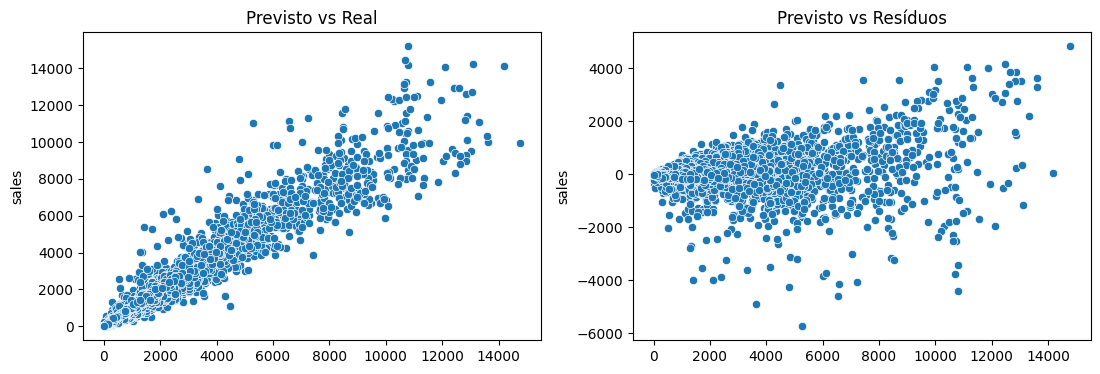

In [67]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.scatterplot(x=y_hat, y=y_test)
plt.title('Previsto vs Real')
plt.subplot(1,2,2)
sns.scatterplot(x=y_hat, y=resids)
plt.title('Previsto vs Resíduos')

plt.show()

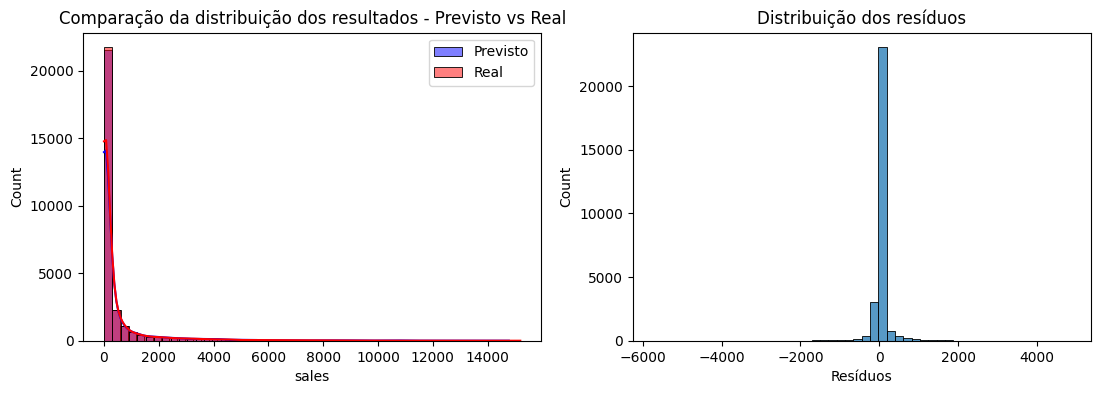

In [83]:
plt.figure(figsize=(13,4))

plt.subplot(1, 2, 1)
sns.histplot(y_hat, bins=50, color='blue', kde=True, label='Previsto')
sns.histplot(y_test, bins=50, color='red', kde=True, label='Real')
plt.title("Comparação da distribuição dos resultados - Previsto vs Real")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(resids, bins=50)
plt.title('Distribuição dos resíduos')
plt.xlabel('Resíduos')

plt.show()

## Gerando arquivo submission.csv

In [69]:
# Treinando na base de dados completa e com parâmetros otimizados

# params = {'n_estimators': 5298, 'learning_rate': 0.06866280344686139, 'num_leaves': 35} #0,52639
# params = {'n_estimators': 3255, 'learning_rate': 0.5361607040524079, 'num_leaves': 37}  #0,46876
# param = {'n_estimators': 5235, 'learning_rate': 0.08355982604033535} #0,50116
# params = {'n_estimators': 3636, 'learning_rate': 0.18509657830618118, 'num_leaves': 27, 'subsample_for_bin ': 2470898, 'min_child_samples': 15} #0,49951
# params = {'n_estimators': 1059, 'learning_rate': 0.5047559096598204, 'num_leaves': 42, 'min_child_samples': 22, 'min_child_weight': 0.03624596281860057, 'max_depth': 8} #0,50723
# params = {'n_estimators': 3255, 'learning_rate': 0.5047559096598204, 'num_leaves': 42, 'min_child_samples': 22, 'min_child_weight': 0.03624596281860057, 'max_depth': 8} #0,47526
params = {'n_estimators': 1381, 'learning_rate': 0.39168448692914676, 'num_leaves': 29, 'min_child_samples': 23, 'min_child_weight': 0.08043993679621202, 'max_depth': 16} #0,50486

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_jobs=-1, verbose=1, **params)),
])

model_pipeline.fit(data.drop(columns='sales'), np.log1p(data['sales']))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 2988414, number of used features: 168
[LightGBM] [Info] Start training from score 2.930884


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categ_nom',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['store_nbr', 'family',
                                                   'city', 'state', 'type',
                                                   'cluster', 'local_holiday',
                                                   'regional_holiday',
                                                   'national_holiday']),
                                                 ('numeric_cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('variance',
                                                                   VarianceThreshold(threshold=0.5))]),
                                                  ['onpromotion', 'dcoilwtico',
                                                   'sales_lag_1', 'sales_lag_2',
                                                   'sales_lag_3', 'sales_lag_4',
                                                   'sales_lag_5', 'sales_lag_6',
                                                   'sales_lag_7'])])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.39168448692914676, max_depth=16,
                               min_child_samples=23,
                               min_child_weight=0.08043993679621202,
                               n_estimators=1381, n_jobs=-1, num_leaves=29,
                               verbose=1))])

In [70]:
test = pd.read_csv(
    './Data/test.csv',
    parse_dates=['date'],
    dtype={'family': 'category', 'store_nbr': 'category'}
)

test = pd.concat([train, test])
test = preprocessing_datasets(test, stores, holidays_events, oil).set_index('date')
test = make_lags(test, 7, drop_null=False)

In [71]:
# Loop para previsão dos 16 dias usando estratégia recursiva

for index in test.loc['2017-08-16':].index.unique():
    print(index)
    x = test.loc[index]
    x = x.drop(columns=['sales', 'id'])

    predict = model_pipeline.predict(x)
    predict = np.maximum(predict, 0)
    
    test.loc[index, 'sales'] = np.expm1(predict)

    test.loc[:, 'sales_lag_1'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(1)
    test.loc[:, 'sales_lag_2'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(2)
    test.loc[:, 'sales_lag_3'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(3)
    test.loc[:, 'sales_lag_4'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(4)
    test.loc[:, 'sales_lag_5'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(5)
    test.loc[:, 'sales_lag_6'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(6)
    test.loc[:, 'sales_lag_7'] = test.groupby(['store_nbr', 'family'], observed=False)['sales'].shift(7)

2017-08-16 00:00:00
2017-08-17 00:00:00
2017-08-18 00:00:00
2017-08-19 00:00:00
2017-08-20 00:00:00
2017-08-21 00:00:00
2017-08-22 00:00:00
2017-08-23 00:00:00
2017-08-24 00:00:00
2017-08-25 00:00:00
2017-08-26 00:00:00
2017-08-27 00:00:00
2017-08-28 00:00:00
2017-08-29 00:00:00
2017-08-30 00:00:00
2017-08-31 00:00:00


In [72]:
test.loc['2017-08-16':][['id', 'sales']].to_csv('submission.csv', index=False)